## 도시별(제주시/서귀포시) 정류장 DBSCAN 군집화를 위한 권장 eps값 산출

In [1]:
import os
# Do! 프로젝트 root 경로로 설정
project_path = "D:/Users\workspace/2.jeju-bus-stations-clustering_MH"
os.chdir(project_path)

In [6]:
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numbers
import math

import bus.analyzer as anz

#### 1-1 정류장 파일 읽어온 뒤, 'city(시)' 필드 추가
#### 1-2 제주시, 서귀포시 정류장 dataframe 생성
#### 1-3 제주시, 서귀포시 정류장 min<sub>eps</sub> /단위: m 리스트 생성
#### 1-4 테스트 gap /단위: m 할당

In [7]:
result_path = 'data/image'
path = r'D:\jeju_bus_data_no_leakage\station'.replace('\\', '/')
df = anz.load_station_df()
df['city'] = df['station_address']
df.loc[:, 'city'] = df.loc[:, 'station_address'].apply(lambda string: string.split(' ')[1])
                    # (예) 'STATION_ADDR': 서귀포시 중문동 ... ☞ 'city': 서귀포시

df_jeju_station     = df.query('city == "제주시"')
df_seogwipo_station = df.query('city == "서귀포시"')

list_station_df_per_city = [df_jeju_station, df_seogwipo_station]
list_min_eps    = [50, 55]
list_min_maxEps = [160, 250]
gap             = 10

#### 2-1 DBSCAN 클러스터링 관련 함수 구현

In [13]:
def get_n_level_spatial_dbscan_result \
    (n, eps, df, df_cols=['station_longitude','station_latitude'], algorithm='ball_tree', metric='haversine', min_pts=3, eps_measure='m'):
    earth_radius = 6371.0088 # 단위: km
    div = 1000 if eps_measure == 'm' else 1
    dbscan = DBSCAN(eps=eps/div/earth_radius, min_samples=min_pts, algorithm=algorithm, metric=metric)

    temp_df = df.loc[:, df_cols]
    temp_df.loc[:, 'target'] = dbscan.fit_predict(np.radians(temp_df))
    
    success_index = temp_df.query('target > -1').index ; temp_df.loc[success_index, 'level'] = n 
    failed_index = set(temp_df.index) - set(success_index) ; temp_df.loc[failed_index, 'level'] = -1
    
    return temp_df

In [18]:
def get_noise_handled_result(df, df_cols=['station_longitude','station_latitude'], n=3, column1='station_name', column2='station_id'):
    df.loc[:, 'target'] = -1 ; df.loc[:, 'level'] = -1
    
    grouped = df.groupby(by = column1, as_index = False)
    list_station_nm = list(grouped.count()[grouped.count()[column2] >= 2][column1])
    target_range = np.arange(len(list_station_nm))
    
    for i in target_range:
        list_idx = df.query('%s == "%s"' % (column1, list_station_nm[i])).index
        for idx in list_idx: 
            df.loc[idx, 'target'] = i
            df.loc[idx, 'level'] = n
    
    return df[df_cols + ['target', 'level']]

In [19]:
def get_noise_result(df, n=4):
    df.loc[:, 'level'] = n ; return df

In [20]:
def get_spatial_dbscan_result(eps, station_df):
    df_lv1_group = get_n_level_spatial_dbscan_result(1, eps, station_df)
    df_lv2_group = get_n_level_spatial_dbscan_result(2, eps, df_lv1_group.query('target == -1'), min_pts=2)

    df_noise_handled_group = get_noise_handled_result(station_df.loc[df_lv2_group.query('target == -1').index])
    df_noise_group = get_noise_result(df_noise_handled_group.query('target == -1'))

    r1 = df_lv1_group.query('target > -1')
    r2 = df_lv2_group.query('target > -1')
    r3 = df_noise_handled_group.query('target > -1')
    r4 = df_noise_group

    combined = pd.concat([r1, r2, r3, r4])
    return combined

#### 2-2 클러스터링에 따른 레벨별 정류장 군집 개수 통계 & 시각화
#### Lv1. -> full-scan / minPts = 3 Clustering
#### Lv2. -> Lv1.-noise-scan / minPts = 2 Clustering
#### Lv3. -> Lv2.-noise-scan / 동일 정류장명으로 Clustering (엄밀히는 DBSCAN 기법 미사용)
#### Lv4. -> Lv3.-noise / 최종 노이즈

In [30]:
list_station_cnt_per_group_per_level_per_eps_per_city = []

for i, station_df in enumerate(list_station_df_per_city):
    eps_range = np.arange(list_min_eps[i], list_min_maxEps[i] + gap, gap)

    list_station_cnt_per_group_per_level_per_eps_per_city.append(pd.DataFrame(columns=[1., 2., 3., 4.]))

    for eps in eps_range:
        # eps에 따른 dbscan 수행.
        df_combined = get_spatial_dbscan_result(eps, station_df)
        
        # lv별 grouping -> count -> 저장.
        df_cnt_per_level = df_combined.groupby(by='level')['level'].count()
        list_station_cnt_per_group_per_level_per_eps_per_city[i] = \
            list_station_cnt_per_group_per_level_per_eps_per_city[i] \
            .append(dict(df_cnt_per_level), ignore_index=True)

D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [31]:
def show_and_save_fig_station_cnt_per_group_per_level_per_eps_per_city(fig_title, i, path=result_path):
    instance = list_station_cnt_per_group_per_level_per_eps_per_city[i]

    plt.rcParams['font.size'] = 12
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.figure(figsize=(10, 6.6))
    plt.grid(True, which='both')

    y_max = instance.max().max()
    plt.yticks(np.arange(0, y_max, 50))
    
    plt.xticks(np.arange(len(instance)))

    plt.xlabel('eps Level (0: %sm, gap: %sm)' % (list_min_eps[i], gap))
    plt.ylabel('군집 개수')
    plt.title(fig_title)
    plt.plot(instance)
    plt.legend(['Lv.1', 'Lv.2', 'Lv.3', 'Noise'])
    plt.gcf().savefig(path + '/' + fig_title)
    plt.show()

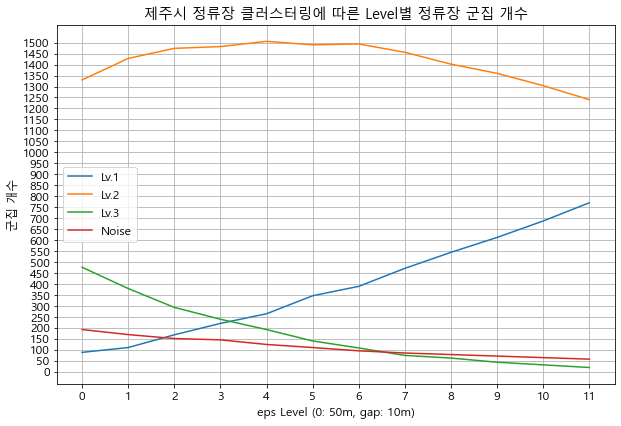

In [32]:
show_and_save_fig_station_cnt_per_group_per_level_per_eps_per_city\
('제주시 정류장 클러스터링에 따른 Level별 정류장 군집 개수', 0)

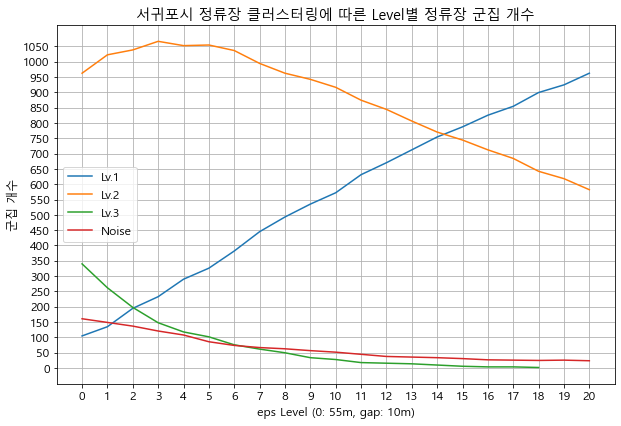

In [33]:
show_and_save_fig_station_cnt_per_group_per_level_per_eps_per_city\
('서귀포시 정류장 클러스터링에 따른 Level별 정류장 군집 개수', 1)

#### 2-3 클러스터링에 따른 <레벨1> 군집 내 정류장 평균 개수 및 최대 개수 통계 & 시각화
#### 레벨2, 3는 진행하지 않는다 -> 평균 개수, 최대 개수가 항상 2일 수 밖에 없기 때문이다.

In [34]:
list_mean_max_station_cnt_per_group_per_level_1_per_eps_per_city = []

for i, station_df in enumerate(list_station_df_per_city):
    eps_range = np.arange(list_min_eps[i], list_min_maxEps[i] + gap, gap)
    list_mean_max_station_cnt_per_group_per_level_1_per_eps_per_city.append(pd.DataFrame(columns=['mean', 'max']))

    for eps in eps_range:
        # eps에 따른 dbscan 수행.
        df_combined = get_spatial_dbscan_result(eps, station_df)
        df_lv1_group = df_combined.query('level==1.')
        df_cnt_per_group = df_lv1_group.groupby(by='target').count()
        
        dic = {'mean': df_cnt_per_group.mean()['level'], 'max': df_cnt_per_group.max()['level']}
        list_mean_max_station_cnt_per_group_per_level_1_per_eps_per_city[i] = \
            list_mean_max_station_cnt_per_group_per_level_1_per_eps_per_city[i].append(dic, ignore_index=True)

D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [35]:
def show_and_save_fig_list_mean_max_station_cnt_per_group_per_level_1_per_eps_per_city(fig_title, i, path=result_path):
    instance = list_mean_max_station_cnt_per_group_per_level_1_per_eps_per_city[i]

    plt.rcParams['font.size'] = 12
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.figure(figsize=(10, 6.6))
    plt.grid(True, which='both')

    y_max = instance.max().max()
    plt.yticks(np.arange(0, y_max, 1 if y_max < 20 else 10))
    plt.xticks(np.arange(len(instance)))

    plt.xlabel('eps Level (0: %sm, gap: %sm)' % (list_min_eps[i], gap))
    plt.ylabel('군집 내 정류장 개수')
    plt.title(fig_title)
    plt.plot(instance)
    plt.legend(['평균', '최대'])
    plt.gcf().savefig(result_path + '/' + fig_title.replace('\n', '').replace('.', ''))
    plt.show()

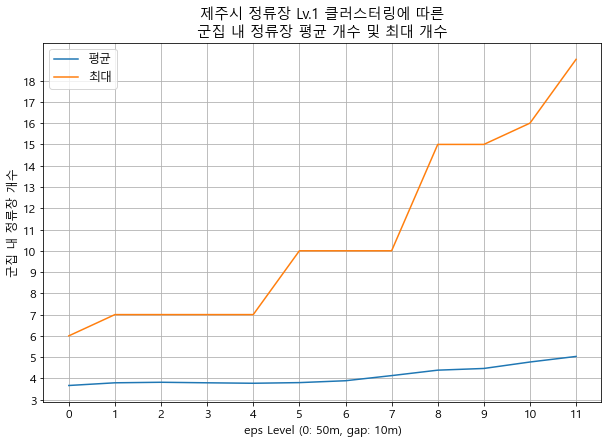

In [36]:
show_and_save_fig_list_mean_max_station_cnt_per_group_per_level_1_per_eps_per_city \
('제주시 정류장 Lv.1 클러스터링에 따른\n군집 내 정류장 평균 개수 및 최대 개수', 0)

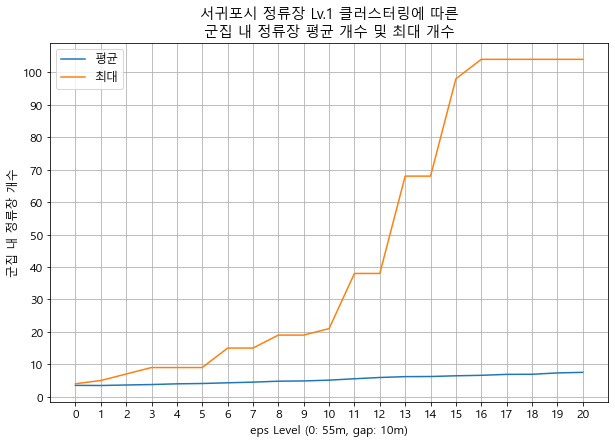

In [37]:
show_and_save_fig_list_mean_max_station_cnt_per_group_per_level_1_per_eps_per_city \
('서귀포시 정류장 Lv.1 클러스터링에 따른\n군집 내 정류장 평균 개수 및 최대 개수', 1)

#### 2-4 클러스터링에 따른 <레벨1> 군집 내 정류장 간 평균 거리 / 최대 거리 통계 & 시각화
#### 레벨2, 3는 진행하지 않는다 -> 군집의 크기가 크지 않을 것이 분명히 예상되므로

In [38]:
def get_haversine_distance(lon_lat_list, round_decimal_digits=5, metric='meter'):
    def degree2radius(degree): return degree * (math.pi/180)
    
    if len(lon_lat_list) < 4: return None
    
    x1, y1, x2, y2 = lon_lat_list[0], lon_lat_list[1], lon_lat_list[2], lon_lat_list[3]
    assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
    assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
    assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
    assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

    R = 6371 # 지구의 반경(단위: km)
    dLon = degree2radius(x2-x1) ; dLat = degree2radius(y2-y1)

    a = math.sin(dLat/2) * math.sin(dLat/2) + (math.cos(degree2radius(y1)) * math.cos(degree2radius(y2)) * math.sin(dLon/2) * math.sin(dLon/2))
    b = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return round(R * b * 1000 if metric == 'meter' else 1, round_decimal_digits)

In [46]:
def get_cartesian_product_result(df1, df2, columns=['station_longitude', 'station_latitude'], distinct=True):
    df1['_tmpkey'], df2['_tmpkey'] = 1, 1
    cols = pd.Series(columns * 2) + pd.Series(['_x', '_x', '_y', '_y'])
    
    df = pd.merge(df1, df2, on='_tmpkey').drop('_tmpkey', axis=1)[cols]
    if distinct: df = df.query('station_longitude_x != station_longitude_y and station_latitude_x != station_latitude_y') 
        #df.query('%s != %s and %s != %s' % tuple(cols))
    
    return df

In [47]:
list_mean_max_station_by_station_dist_per_group_per_level_per_eps_per_city = []

for i, station_df in enumerate(list_station_df_per_city):
    eps_range = np.arange(list_min_eps[i], list_min_maxEps[i] + gap, gap)
    list_mean_max_station_by_station_dist_per_group_per_level_per_eps_per_city \
    .append(pd.DataFrame(columns=['mean', 'max']))

    for eps in eps_range:
        # eps에 따른 dbscan 수행.
        df_combined = get_spatial_dbscan_result(eps, station_df)
        df_lv1_group = df_combined.query('level==1.')
        
        list_lv1_target_domain = df_lv1_group['target'].unique()        
        
        df_mean_max_per_eps = pd.DataFrame(columns=['mean', 'max'])
        for target in list_lv1_target_domain:
            list_idx = df_lv1_group.query('target==%s' % target).index
            
            # cspd1 x cspd2 카티션 곱
            df_cspd1 = station_df.loc[list_idx].groupby(by='station_name').mean()
            df_cspd2 = station_df.loc[list_idx].groupby(by='station_name').mean()
            
            # df_cspd1(2)에 1개 행만 있는 경우 카티시안 프로덕트 연산이 제대로 수행되지 못하는
            # 오류가 발견됨. 이에 따라 아래와 같이 코드 수정.
            # 행이 1개만 존재할 수 있는 이유는? 위에서 groupby -> mean 연산 수행해서...
            # 의의: 동일 명칭 정류장은 위/경도 값이 거의 일치하므로 두 정류장의 평균값을 구해서 요약해놓아도 무방.
            if len(df_cspd1) < 2:
                dic = {'mean': 0, 'max': 0}
                # dist는 0으로 처리해야 함.
                # <- 코드 마져 작성 요망...
            
            else:
                df_cspd = get_cartesian_product_result(df_cspd1, df_cspd2)
                df_cspd['dist'] = [get_haversine_distance(list(df_cspd.loc[idx])) for idx in df_cspd.index]
                dic = {'mean': df_cspd['dist'].mean(), 'max': df_cspd['dist'].max()}
            
            df_mean_max_per_eps = df_mean_max_per_eps.append(dic, ignore_index=True)
        

        list_mean_max_station_by_station_dist_per_group_per_level_per_eps_per_city[i] = \
                list_mean_max_station_by_station_dist_per_group_per_level_per_eps_per_city[i]. \
                append({'mean': df_mean_max_per_eps.mean()['mean'], \
                        'max': df_mean_max_per_eps.max()['max']}, \
                ignore_index=True)

D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Users\Embedded\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [48]:
def show_and_save_fig_list_mean_max_station_by_station_dist_per_group_per_level_per_eps_per_city \
    (fig_title, i, path=result_path):
    instance = list_mean_max_station_by_station_dist_per_group_per_level_per_eps_per_city[i]

    plt.rcParams['font.size'] = 12
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.figure(figsize=(10, 6.6))
    plt.grid(True, which='both')

    y_max = instance.max().max()
    
    plt.yticks(np.arange(0, y_max, 50 if y_max < 1100 else 100))
    plt.xticks(np.arange(len(instance)))

    plt.xlabel('eps Level (0: %sm, gap: %sm)' % (list_min_eps[i], gap))
    plt.ylabel('군집 내 정류장 간 거리(m)')
    plt.title(fig_title)
    plt.plot(instance)
    plt.legend(['평균', '최대'])
    plt.gcf().savefig(result_path + '/' + fig_title.replace('\n', '').replace('.', ''))
    plt.show()

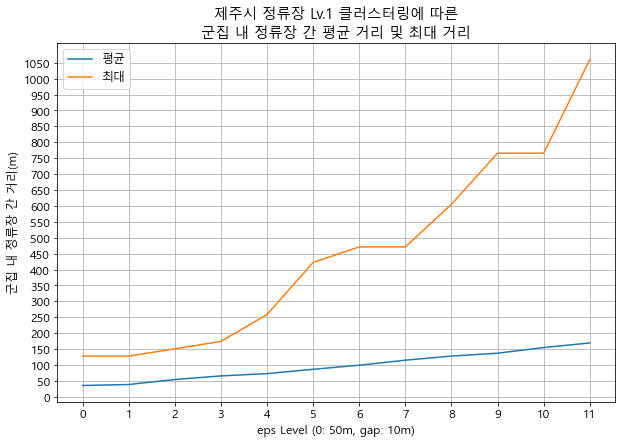

In [49]:
show_and_save_fig_list_mean_max_station_by_station_dist_per_group_per_level_per_eps_per_city \
('제주시 정류장 Lv.1 클러스터링에 따른\n군집 내 정류장 간 평균 거리 및 최대 거리', 0)

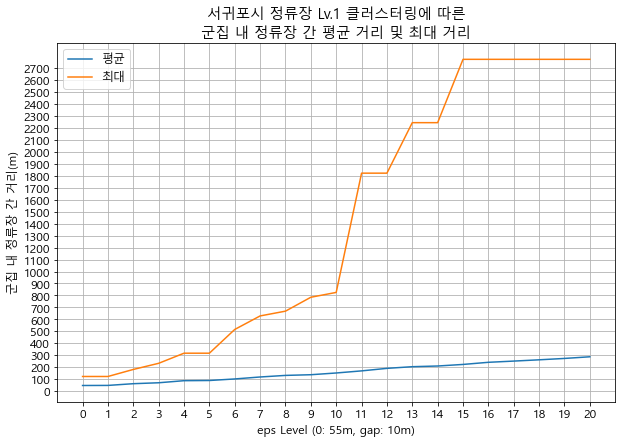

In [50]:
show_and_save_fig_list_mean_max_station_by_station_dist_per_group_per_level_per_eps_per_city \
('서귀포시 정류장 Lv.1 클러스터링에 따른\n군집 내 정류장 간 평균 거리 및 최대 거리', 1)